# Tarea 2: Backpropagation, descenso de gradiente y entrenamiento <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Matias Cornejo
Fecha de entrega: 6 de octubre de 2021

Para la **corrección automática** hemos creado una funcionalidad nueva que les permite comprobar el tiempo que demora su solución. En colab estos tiempos pueden ser variables entre una ejecución y otra del mismo código. No se preocupen si les falla el test por `time` algunas veces. Pueden hacer `time=0` en la ultima linea de cada test para evitar estos errores. También hemos usado nombres para los tests. Estos pueden serles de ayuda para determinar qué partes de su implementación deben corregir ;-)


In [ ]:
# Este notebook está pensado para correr en CoLaboratory.
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-cvi23fna/cc6204_daafa5da316440218e73df4dfd5d87e1
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-cvi23fna/cc6204_daafa5da316440218e73df4dfd5d87e1
  Created wheel for cc6204: filename=cc6204-0.5.0-py3-none-any.whl size=5800 sha256=263e9a977fe195db899842769667ea93b0d78bfdd6d1a147857110d5b3f7f0e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-mzp8542a/wheels/3c/26/f5/2abeb546c3ff1ab6e69113a3ae69bc0ac3442642727fd0dcc2
Successfully built cc6204


In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Preliminares: funciones de activación y función de error


## 1a) Derivando las funciones de activación

Escribe acá tus respuestas para las derivadas de cada función de activación.

$$ relu(x)=   \left\{
\begin{array}{ll}
      0 & x \leq 0 \\
      x & x>0 \\
\end{array}
\right.  $$

$$ swish(x, \beta)= x * sigmoid(\beta * x) $$

$$ celu(x, a)=   \left\{
\begin{array}{ll}
      x & x \geq 0 \\
      \alpha * ( exp(\frac{ x}{a}) - 1) & x<0 \\
\end{array}
\right.  $$

<br>
$$
\frac{\partial\ \text{relu}(x)}{\partial x} =  
 \left\{
\begin{array}{ll}
      0 & x < 0 \\
      1 & x>0 \\
\end{array}
\right.$$
<br>

$$
\frac{\partial\ \text{swish}(x, \beta)}{\partial x} =  sigmoid(\beta * x) + x*\beta *sigmoid(\beta * x)(1−sigmoid(\beta * x)) $$
$$=  sigmoid(\beta * x) + x * \beta * sigmoid(\beta * x)− x * \beta * sigmoid^2(\beta * x) $$
$$=   \beta * swish(\beta * x) + sigmoid(\beta * x) − x * \beta * sigmoid^2(\beta * x) $$
$$=   \beta * swish(\beta * x) + sigmoid(\beta * x) (1 − x * \beta * sigmoid(\beta * x)) $$
$$=   \beta *swish(\beta * x) + sigmoid(\beta * x) (1 − \beta * swish(x)) $$

<br>

$$
\frac{\partial\ \text{swish}(x, \beta)}{\partial \beta} =  x * \beta * sigmoid(\beta * x)(1−sigmoid(\beta * x))$$
<br>

$$
\frac{\partial\ \text{celu}(x, \alpha)}{\partial x} =  
 \left\{
\begin{array}{ll}
      1 & x \geq 0 \\
      exp(\frac{ x}{a}) & x<0 \\
\end{array}
\right.$$
<br>

$$
\frac{\partial\ \text{celu}(x, \alpha)}{\partial \alpha} =  
 \left\{
\begin{array}{ll}
      0 & x \geq 0 \\
      exp(\frac{ x}{a}) (1- \frac{x}{a}) -1  & x<0 \\
\end{array}
\right.$$

In [ ]:
# Más adelante en la tarea necesitaremos usar las funciones de activación
# que implementaste en la Tarea 1 y sus derivadas.
# Acá implementa las derivadas de las funciones de activación

# Una forma de implementarlas (tal vez no la mejor) es reutilizando la misma función
def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T):
  return torch.max(torch.zeros_like(T),T)

def swish(T, b):
  return T * (sig(b * T))

def celu(T, a): #CELU(x)=max(0,x)+min(0,α∗(exp(x/α)−1))
  return relu(T) + torch.min(torch.zeros_like(T), a * (torch.exp( T/a ) - 1))

def softmax(T, dim, estable=True):
  return torch.exp(T) / torch.sum(torch.exp(T), dim = dim, keepdim=True)

## 1b) Entropía Cruzada

In [ ]:
# Tu código acá
def CELoss(Q, P, estable=True, epsilon=1e-8):
  # Q y P: representan distribuciones de probabilidad discreta
  #        (mediante matrices con las mismas dimensiones)
  # estable y epsilon: nos permiten lograr estabilidad numérica cuando
  #       intentamos computar el logaritmo de valores muy pequeños.
  #       epsilon limitará el valor mínimo del valor original cuando estable=True
  N = Q.shape[0]
  M = Q.shape[1]

  if estable:
    CEi = 0
    for i in range(N):
      CEi += (-1) * torch.sum(P[i] * torch.log(torch.max(torch.ones_like(Q[i])*epsilon, Q[i])))
  else:
    CEi = 0
    for i in range(N):
      CEi += (-1) * torch.sum(P[i] * torch.log(Q[i]))

  return CEi / N

In [ ]:
# Tests del API del curso
for test in ['small', 'estable', 'eps', 'no-estable']:
  # Obtengamos dos distribuciones de probabilidad y los parametros estable y epsilon
  Q, P, estable, eps = corrector.get_test_data(homework=2, question="1b", test=test, token=token)
  # Corramos tu implementacion de CELoss para ver como se comporta
  s = timer()
  result = CELoss(Q=torch.Tensor(Q), P=torch.Tensor(P), estable=estable, epsilon=eps)
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  t = 0
  corrector.submit(homework=2, question="1b", test=test, token=token, answer=result, time=t)

Correct Test!
Correct Test!
Correct Test!
Correct Test!


## 1c) Opcional: Entropía Cruzada Categórica

In [ ]:
# No es necesario que entregues código en esta parte.
# Pero si quieres, igual hay espacio ;-)

# Parte 2: Más derivadas y back propagation

## 2a) Derivando la última capa

Escribe tu cálculo acá.
<br>

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}} =
\end{equation}
<br>

\begin{equation}
\frac{\partial \cal L}{\partial u_i^{(L+1)}} = \frac{\partial \cal L}{\partial \hat y_j} \frac{\partial \hat y_j}{\partial u_i^{(L+1)}}
\end{equation}

Primero $$\cal L=-\frac{1}{N} \sum_{x}p(x)\log q(x) = =-\frac{1}{N} \sum_{k}y_k \log q(\hat y_k)$$
Entonces, \begin{equation}
\frac{\partial \cal L}{\partial u_i^{(L+1)}} = -\frac{1}{N} \sum_{k}y_k \frac{\partial\log \hat y_k}{\partial u_i^{(L+1)}} = -\frac{1}{N} \sum_{k} \frac{y_k}{\hat y_k} \frac{\partial \hat y_k}{\partial u_i^{(L+1)}}
\end{equation}
<br>


Sabemos  que $\hat y=\text{softmax}(u_i^{(L+1)})$ y que $\text{softmax}(x_k) = s(x_k) = \frac{exp(x_k)}{\sum_{j}exp(x_j)}$

Por partes,  $\frac{\partial exp(x_k)}{\partial x_i} = exp(x_k) \frac{\partial x_k}{\partial x_i} = exp(x_k) * (1\{i=k\})$
<br>

y, $\frac{\partial \sum_{j} exp(x_j)}{\partial x_i} = \sum_{j} \frac{ \partial exp(x_j)}{\partial x_i} = \sum_{j} exp(x_j)\frac{ \partial x_j}{\partial x_i} = exp(x_i)$

Entonces,

\begin{equation}
\frac{\partial s(x_k)}{\partial x_i} = \frac{(exp(x_k) * (1\{i=k\}))(\sum_{j} exp(x_j)) - (exp(x_i))(exp(x_k))}{[\sum_{j} exp(x_j)]^2}
\end{equation}

\begin{equation}
= \frac{exp(x_k)}{\sum_{j} exp(x_j) } * (1\{i=k\}) - \frac{exp(x_i)}{\sum_{j} exp(x_j) }\frac{exp(x_k)}{\sum_{j} exp(x_j) }
\end{equation}
<br>

\begin{equation}
= s(x_k) * (1\{i=k\}) - s(x_i)*s(x_k)
\end{equation}
<br>
\begin{equation}
= s(x_k) * ((1\{i=k\}) - s(x_i))
\end{equation}
<br>

Finalmente,

\begin{equation}
\frac{\partial \cal L}{\partial \theta_{i}} = -\frac{1}{N} \sum_{k} \frac{y_k}{\hat y_k} * \hat y_k * ((1\{i=k\}) - \hat y_{i}) = -\frac{1}{N} \sum_{k} y_k ((1\{i=k\}) - \hat y_{i})
\end{equation}

$$ = \frac{1}{N} [(\sum_{k \neq i } y_k * \hat y_{i}) -  y_i + y_i * \hat y_i)] = \frac{1}{N} [(\sum_{k } y_k * \hat y_{i}) -  y_i] = \frac{1}{N} [(\hat y_{i}\sum_{k } y_k) - y_i]  $$
$y$ es una distribución de probabilidad, por lo que $\sum_k y_k = 1$, es decir:

<br>
$$\frac{\partial \cal L}{\partial \theta_{i}} =\frac{1}{N} [\hat y_{i} - y_i]$$

In [ ]:
# Para ir chequeando que al menos las dimensiones de los tensores son
# consistentes usaremos las varibles *dummy* a continuación.
B, C = 5, 10
y = torch.ones(B,C)
y_pred = torch.ones(B,C)

In [ ]:
# Acá tu trozo de código.
# Primero agregamos algunas variables dummy para chequear
# que al menos las dimensiones están correctas
dimL = 40
hL = torch.ones(B,dimL)
U = torch.ones(dimL,C)
c = torch.ones(C)
uLm1 = hL @ U + c

result = CELoss(y, y_pred)

# Ahora define aca tu fórmula para el gradiente
dL_duLm1 = (1 / B) * (y_pred - y)

# El gradiente debe coincidir en dimensiones con la variable
assert dL_duLm1.size() == uLm1.size()

## 2b) Derivando la última capa (continuación)

<br>
tenemos que: $u^{(L+1)}_{s,j} = h^{(L)}_{s,i}U_{i,j}+c_{j}$
<br>
Por lo que,
\begin{equation}
\frac{\partial\cal L}{\partial U_{i,j}} = \frac{\partial\cal L}{\partial u^{L+1}_{s,j}} \frac{\partial u^{L+1}_{s,j}}{\partial U_{i,j}} \\
\end{equation}
<br>

donde $\frac{\partial u^{L+1}_{s,j}}{\partial U_{i,j}} = h^{(L)}_{s,i}$ y $ \frac{\partial\cal L}{\partial u^{L+1}_{s,j}} $ la conocemos del paso anterior

Quedando: $\frac{\partial\cal L}{\partial U_{i,j}} = (h^{(L)}_{s,i})^T \ @ \ \frac{\partial\cal L}{\partial u^{L+1}_{s,j}}$

de igual manera:
\begin{equation}
\frac{\partial\cal L}{\partial c_j} = \frac{\partial\cal L}{\partial u^{L+1}_{s,j}} \frac{\partial u^{L+1}_{s,j}}{\partial c_j}\\
\end{equation}
<br>

donde $\frac{\partial u^{L+1}_{s,j}}{\partial c_j} = 1_j $

Quedando: $\frac{\partial\cal L}{\partial c_{j}} = \frac{\partial\cal L}{\partial u^{L+1}_{s,j}} * 1_j = sum(\frac{\partial\cal L}{\partial u^{L+1}_{s,j}})$

\begin{equation}
\frac{\partial\cal L}{\partial h_{i,j}^{L}} = \frac{\partial\cal L}{\partial u^{L+1}_{s,j}} \frac{\partial u^{L+1}_{s,j}}{\partial h_{i,j}^{L}} \\
\end{equation}
<br>


donde $\frac{\partial u^{L+1}_{s,j}}{\partial h_{i,j}^{L}} = U_{i,j}$

Quedando: $\frac{\partial\cal L}{\partial c_{j}} = \frac{\partial\cal L}{\partial u^{L+1}_{s,j}} * U_{i,j} = \frac{\partial\cal L}{\partial u^{L+1}_{s,j}}\ @ \ (U_{i,j})^T $



## 2c) Derivando desde las capas escondidas

Escribe tus respuestas acá. Repite los siguientes cálculos para $\text{relu}, \text{celu}, \text{swish}$
<br>

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial\cal L}{\partial h^{(k)}} \frac{\partial h^{(k)}}{\partial u^{(k)}} \\
\end{equation}
<br>

Con $h^{(k)} = f(h^{(k-1)}W^{(k)}+b^{(k)}) = f(u^{(k)})$, y $\frac{\partial\cal L}{\partial h^{(k)}}$ conocido del paso anterior.

Para $h^{(k)}= \text{relu}$,
$$
\frac{\partial\ h^{(k)}(u^{(k)})}{\partial u^{(k)}} =  
 \left\{
\begin{array}{ll}
      0 & u^{(k)} < 0 \\
      1 & u^{(k)} >0 \\
\end{array}
\right.$$

Para $h^{(k)}= \text{celu}$,
$$
\frac{\partial\ h^{(k)}(u^{(k)}, \alpha)}{\partial  u^{(k)}} =  
 \left\{
\begin{array}{ll}
      1 &  u^{(k)} \geq 0 \\
      exp(\frac{ u^{(k)}}{a}) &  u^{(k)}<0 \\
\end{array}
\right.$$
<br>

Para $h^{(k)}= \text{swish}$,
$$\frac{\partial\ h^{(k)}(u^{(k)}, \beta)}{\partial  u^{(k)}} = \beta *swish(\beta * u^{(k)}) + sigmoid(\beta * u^{(k)}) (1 − \beta * swish(u^{(k)})) $$

<br>
Nuevamente,

\begin{equation}
\frac{\partial\cal L}{\partial W^{(k)}} = \frac{\partial\cal L}{\partial u^{(k)}} \frac{\partial u^{(k)}}{\partial  W^{(k)}} \\
\end{equation}
<br>

Con $u^{(k)} = h^{(k-1)}W^{(k)}+b^{(k)}$, y $\frac{\partial\cal L}{\partial u^{(k)}}$ conocido del paso anterior.

Entonces, \\

$$ \frac{\partial u^{(k)}}{\partial W^{(k)}} = h^{(k-1)}$$

<br>

Nuevamente,

\begin{equation}
\frac{\partial\cal L}{\partial b^{(k)}} = \frac{\partial\cal L}{\partial u^{(k)}} \frac{\partial u^{(k)}}{\partial  b^{(k)}} \\
\end{equation}
<br>

Con $u^{(k)} = h^{(k-1)}W^{(k)}+b^{(k)}$, y $\frac{\partial\cal L}{\partial u^{(k)}}$ conocido del paso anterior.

Entonces, \\

$$ \frac{\partial u^{(k)}}{\partial b^{(k)}} = 1_j$$

<br>

Nuevamente,

\begin{equation}
\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial\cal L}{\partial u^{(k)}} \frac{\partial u^{(k)}}{\partial  h^{(k-1)}} \\
\end{equation}
<br>

Con $u^{(k)} = h^{(k-1)}W^{(k)}+b^{(k)}$, y $\frac{\partial\cal L}{\partial u^{(k)}}$ conocido del paso anterior.

Entonces, \\

$$ \frac{\partial u^{(k)}}{\partial h^{(k-1)}} = W^{(k)}$$

In [ ]:
# Acá puedes probar tus cálculos usando código.
# Primero agregamos algunas variables dummy para chequear
# que al menos las dimensiones están correctas.
dimk = 20
dimkm1 = 30
hk = torch.ones(B,dimk)
Wk = torch.ones(dimk,dimkm1)
bk = torch.ones(dimkm1)
uk = hk @ Wk + bk
dL_dhkm1 = torch.ones(B,dimkm1)

# Ahora tu fórmula para el gradiente.
# Esto puedes repetirlo con tus expresiones para relu, celu, y swish.

#relu
dL_duk = dL_dhkm1 * torch.as_tensor(uk > 0, dtype=torch.int32)  #
dL_dWk = hk.t() @ dL_duk
dL_dbk = torch.sum(dL_duk, 0)
dL_dhk = dL_duk @ Wk.t()

# El gradiente debe coincidir en dimensiones con las variables.
assert dL_dWk.size() == Wk.size()
assert dL_dbk.size() == bk.size()
assert dL_dhk.size() == hk.size()

#celu
#torch.as_tensor(uk < 0, dtype=torch.int32)*uk devuelve 0 si es mayor a 0 y uk si es menor a 0
dL_duk = dL_dhkm1 * (torch.exp(torch.as_tensor(uk < 0, dtype=torch.int32)*uk/0.5))  #en este caso alpha = 0.5
dL_dWk = hk.t() @ dL_duk
dL_dbk = torch.sum(dL_duk, 0)
dL_dhk = dL_duk @ Wk.t()

# El gradiente debe coincidir en dimensiones con las variables.
assert dL_dWk.size() == Wk.size()
assert dL_dbk.size() == bk.size()
assert dL_dhk.size() == hk.size()

#swish
dL_duk = dL_dhkm1 * (uk * 0.5 * sig(0.5 * uk) * (1 - sig(0.5 * uk)))  #beta = 0.5
dL_dWk = hk.t() @ dL_duk
dL_dbk = torch.sum(dL_duk, 0)
dL_dhk = dL_duk @ Wk.t()

# El gradiente debe coincidir en dimensiones con las variables.
assert dL_dWk.size() == Wk.size()
assert dL_dbk.size() == bk.size()
assert dL_dhk.size() == hk.size()

# Parte 3: Backpropagation en nuestra red

## 3a) Método `backward` + parte 3b) Opcional

In [ ]:
# Acá solo deberías programar la función backward.
# El resto del código viene de la Tarea 1 (a menos que hayas programado
# la parte opcional en cuyo caso también deberías cambiar el inicializador).
# Puedes incluir todo el código de la Tarea 1 que quieras.
class FFNN(torch.nn.Module):
  # código desde la Tarea 1
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    # Crea los tensores como parámetros
    self.W_h1 = torch.nn.Parameter(torch.randn(F, l_h[0]), requires_grad=True)
    self.b1 = torch.nn.Parameter(torch.zeros(l_h[0]), requires_grad=True)
    self.W_h2 = torch.nn.Parameter(torch.randn(l_h[0], l_h[1]), requires_grad=True)
    self.b2 = torch.nn.Parameter(torch.zeros(l_h[1]), requires_grad=True)
    self.U = torch.nn.Parameter(torch.randn(l_h[1], C), requires_grad=True)
    self.c = torch.nn.Parameter(torch.zeros(C), requires_grad=True)
    self.acv1 = l_a[0]
    self.acv2 = l_a[1]

    #self.params = torch.nn.ParameterList([self.W_h1, self.b1, self.W_h2, self.b2, self.U, self.c])

  # código desde la Tarea 1
  def load_weights(self, Ws, U, bs, c):
    self.W_h1 = torch.nn.Parameter(Ws[0], requires_grad=True)
    self.b1 = torch.nn.Parameter(bs[0], requires_grad=True)
    self.W_h2 = torch.nn.Parameter(Ws[1], requires_grad=True)
    self.b2 = torch.nn.Parameter(bs[1], requires_grad=True)
    self.U = torch.nn.Parameter(U, requires_grad=True)
    self.c = torch.nn.Parameter(c, requires_grad=True)
    #self.params = torch.nn.ParameterList([W_h1, b1, W_h2, b2, U, c])

  def resumen(self):
    # usa self.parameters() o self.named_parameters()
    self.params = self.parameters()

  def forward(self, x):
    # Usa los parámetros y funciones de activación.
    # El valor de retorno debiera ser y = softmax(capa_de_salida).
    u1 = x @ self.W_h1 + self.b1
    h1 = self.acv1(u1)
    u2 = h1 @ self.W_h2 + self.b2
    h2 = self.acv2(u2)
    u3 = h2 @ self.U + self.c
    y_pred = softmax(u3, dim=1)

    self._cache = [u1, u2] # podemos usar un mejor cache?
    return y_pred

  # nuevo código Tarea 2
  def backward(self, x, y, y_pred):
    # Computar acá todos los gradientes con respecto a L
    # Hint: Los gradientes deben quedar almacenados en
    #       el atributo `grad` para cada parámetro.
    #       Más info sobre este atributo en
    #       https://pytorch.org/docs/stable/autograd.html#torch.Tensor.grad


    # recuperamos el "cache"
    u1, u2 = self._cache # podemos usar un mejor cache?

    b = x.size()[0]




    # Estas son derivadas calculadas a mano
    dL_du3 = (1/b) * (y_pred - y)
    dL_dU  = torch.nn.functional.softmax(u2, dim=1).t() @ dL_du3
    dL_dc  = torch.sum(dL_du3, 0)
    dL_dh2 = dL_du3 @ self.U.t()

    if(self.acv2 == relu):
      dL_du2 = dL_dh2 * torch.as_tensor(u2 > 0, dtype=torch.int32)

    elif(self.acv2 == celu):
      dL_du2 = dL_dh2 * (torch.exp(torch.as_tensor(u2 < 0, dtype=torch.int32)*u2/0.5))

    elif(self.acv2 == swish):
      dL_du2 = dL_dh2 * (u2 * 0.5 * sig(0.5 * u2) * (1 - sig(0.5 * u2)))  #beta = 0.5

    elif(self.acv2 == sig):
      dL_du2 = dL_dh2 * sig(u2) * (1 - sig(u2))

    dL_dW2 = self.acv2(u1).t() @ dL_du2
    dL_db2 = torch.sum(dL_du2, 0)
    dL_dh1 = dL_du2 @ self.W_h2.t()

    #dL_du1 = dL_dh1 * (1 - tanh(u1) * tanh(u1))
    if(self.acv1 == relu):
      dL_du1 = dL_dh1 * torch.as_tensor(u1 > 0, dtype=torch.int32)

    elif(self.acv1 == celu):
      dL_du1 = dL_dh1 * (torch.exp(torch.as_tensor(u1 < 0, dtype=torch.int32)*u1/0.5))

    elif(self.acv1 == swish):
      dL_du1 = dL_dh1 * (u1 * 0.5 * sig(0.5 * u1) * (1 - sig(0.5 * u1)))  #beta = 0.5

    elif(self.acv1 == sig):
      dL_du1 = dL_dh1 * sig(u1) * (1 - sig(u1))

    dL_dW1 = x.t() @ dL_du1
    dL_db1 = torch.sum(dL_du1,0)

    # Registra los valores de gradientes en cada tensor (que nos interesa)
    grads = [dL_dW1, dL_db1, dL_dW2, dL_db2, dL_dU, dL_dc]
    params = [self.W_h1, self.b1, self.W_h2, self.b2, self.U, self.c]
    for p, g in zip(params, grads):
      p.grad = g


In [ ]:
# Tests del API del curso
# (estos Tests NO sustituyen al anterior en la verificación de los gradientes)
for test in ['mnist-model']:
  # Obtenemos los parámetos de la red desde el API
  F, l_h, l_a, C, Ws, U, bs, c, X, y = corrector.get_test_data(homework=2, question="3a", test=test, token=token)
  l_a = [f for s in l_a for f in [sig, tanh, relu, celu] if f.__name__ == s]

  # Inicializamos modelo con parámetros del API
  your_model = FFNN(F=F, l_h=l_h, l_a=l_a, C=C)
  your_model.load_weights([torch.Tensor(l) for l in Ws], torch.Tensor(U), [torch.Tensor(l) for l in bs], torch.Tensor(c))


  # Obtenemos el índice del parámetro Ws[1] en la lista de parámetros de tu modelo
  idx = next(i for i, p in enumerate(your_model.parameters()) if p.size() == torch.Tensor(Ws[1]).size() and torch.all(torch.Tensor(Ws[1])==p))

  # Ejecutemos el forward de para input del API
  y_pred = your_model(torch.Tensor(X))

  # Ejecutemos el backward de tu modelo para ver como se comporta
  s = timer()
  your_model.backward(torch.Tensor(X), torch.Tensor(y), y_pred)
  t = timer() - s

  # Veamos todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.submit(homework=2, question="3a", test=test, token=token,
                   answer=list(your_model.parameters())[idx].grad.mean(), time=t)

Correct Test!


## 3c) Opcional: Chequeo de gradiente

In [ ]:
# No es necesario que entregues código en esta parte dado
# que solo es necesario para debuggear que tu implementación está correcta.
# Pero si quieres, igual hay espacio ;-)

# Parte 4: Descenso de gradiente y optimización

## 4a) Descenso de gradiente (estocástico)

In [ ]:
class SGD():
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr

  def step(self):
    # actualiza acá los parámetros a partir del gradiente de cada uno
    for p in self.parameters:
        p.data -= self.lr * p.grad

In [ ]:
# Tests del API del curso
from torch.nn import Parameter
for test in ['small-step', 'big-step', 'random']:
  # Obtengamos una lista de parámetros (con gradientes en .grad) y un valor lr
  ds, gs, lr, idx = corrector.get_test_data(homework=2, question="4a", test=test, token=token)
  parameters = [Parameter(torch.Tensor(d)) for d in ds]
  for p, g in zip(parameters, gs):
    p.grad = torch.Tensor(g)

  # Inicialicemos tu SGD
  optimizer = SGD(parameters, lr)

  # Ejecutemos un paso de tu SGD para ver como se comporta
  s = timer()
  optimizer.step()
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="4a", test=test, token=token,
                   answer=parameters[idx].data, time=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Old method `sumbit` has been renamed to `submit`, please use that instead.


Correct Test!
Correct Test!
Correct Test!


## 4b) Datos para carga

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Aquí tu código.
# Tu clase debiera verse así
class RandomDataset(Dataset):
  def __init__(self, N, F, C):
    R_N_f = torch.rand(N,F)
    self.X = torch.bernoulli(R_N_f)
    self.Y = torch.zeros((N,C))
    idxs = torch.tensor(list([[i,j] for i,j in enumerate(torch.randint(C, (N, 1)))]))
    self.Y[idxs[:,0],idxs[:,1]] = 1

    self.num_features = F
    self.num_classes = C

  def __len__(self):
    return self.X.size()[0]

  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [ ]:
# Inicialicemos un RandomDataset de prueba
N,F,C=100,300,10
your_dataset = RandomDataset(N,F,C)

# Veamos como se comportan __len__ y __getitem__
print("Correct Test!" if len(your_dataset) == N else "Failed Test [len]")
print("Correct Test!" if type(your_dataset[N//2]) == tuple and len(your_dataset[N//3]) == 2 else "Failed Test [getitem]")

Correct Test!
Correct Test!


## 4c) Optimizando los parámetros de la red para datos al azar

In [ ]:
# Tu código acá
def entrenar_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, device='cuda'):
  red.to(device)

  # Inicialicemos un DataLoader para los ejemplos de dataset
  data = DataLoader(dataset, batch_size, shuffle=True)

  # Comienza el entrenamiento
  loss, acc = [], []
  for e in range(1,epochs+1):
    for x, y in data:
      x, y = x.to(device), y.to(device)
      y_pred = red.forward(x)

      l = CELoss(y_pred, y)

      red.backward(x, y, y_pred)

      optimizador.step()

    #Calculo de acc en cada epoca
    sum = 0
    tot = 0
    for x, y in data:
      pred = red.forward(x)
      _, pred = torch.max(pred,1)
      _, y = torch.max(y,1)
      sum += torch.sum(torch.eq(pred, y))
      tot += len(y)
    acc.append(sum / tot)
    loss.append(l)


  return loss, acc

In [ ]:
F, C = 300, 10
dataset = RandomDataset(N, F, C)
red = FFNN(F, [50,30], [relu,sig], C)
optimizador = SGD(red.parameters(), 0.001)
with torch.no_grad():
  loss, acc = entrenar_FFNN(red, dataset, optimizador, epochs=20, batch_size=8, device='cpu')

## 4d) Graficando la pérdida/error en el tiempo

In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, acc):
  # Muestra dos figuras:
  #  (1) gráfico para la lista `loss` (Loss) y
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy")
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc, c='b')
  f2.show()

In [ ]:
#Dataset
F, C = 300, 10
dataset = RandomDataset(N, F, C)

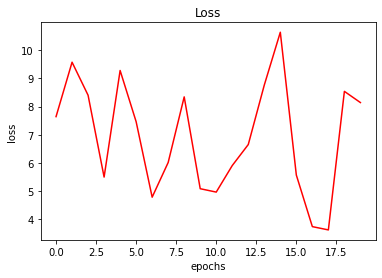

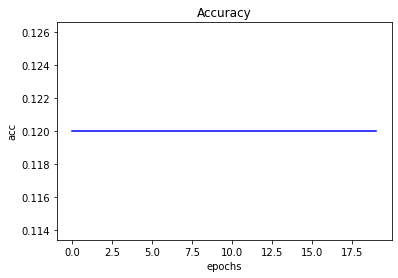

In [ ]:
red = FFNN(F, [50,30], [relu,sig], C)
optimizador = SGD(red.parameters(), 0.001)
with torch.no_grad():
  loss, acc = entrenar_FFNN(red, dataset, optimizador, epochs=20, batch_size=8, device='cpu')
plot_results(loss,acc)

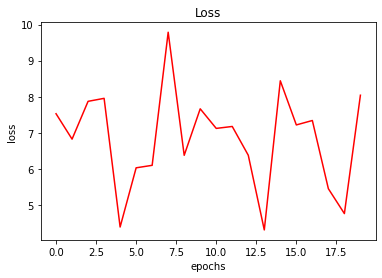

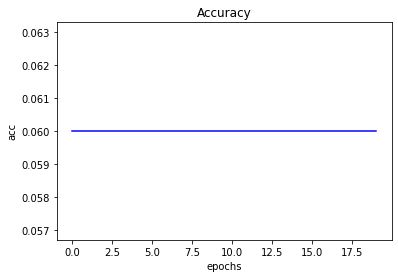

In [ ]:
red = FFNN(F, [100,30], [relu,sig], C)
optimizador = SGD(red.parameters(), 0.001)
with torch.no_grad():
  loss, acc = entrenar_FFNN(red, dataset, optimizador, epochs=20, batch_size=8, device='cpu')
plot_results(loss,acc)

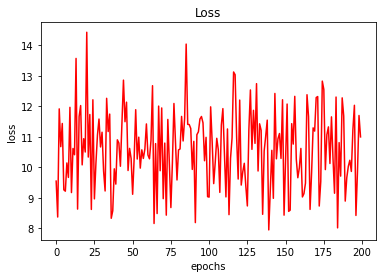

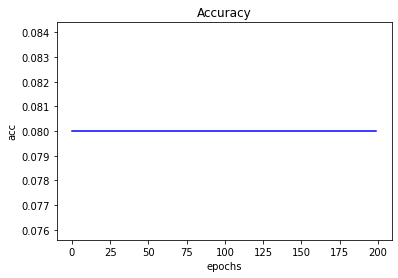

In [ ]:
red = FFNN(F, [100,80], [relu,sig], C)
optimizador = SGD(red.parameters(), 0.0001)
with torch.no_grad():
  loss, acc = entrenar_FFNN(red, dataset, optimizador, epochs=200, batch_size=20, device='cpu')
plot_results(loss,acc)

Dado que el dataset está generado aleatoriamente con 10 clases, dada la ley de los grandes números tiene sentido que la red tenga un resultado de 1/10 = 0.1 de acc aproximadamente. Esto es bastante invariante a la red en si, ya que esta no puede aprender los factores aleatorios del dataset.

## 4e) Opcional: Optimizando tu red para MNIST

In [ ]:
# Tu código de carga de datos, creación de la red,
# entrenamiento/optimización y reportes acá